In [31]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 25. Image registration

## 25.1 Transformation estimation

In [44]:
def toTuple(a):
    """
    function that transforms an array into tuple
    a: array
    """
    try:
        return tuple(toTuple(i) for i in a)
    except TypeError:
        return a

(-0.5, 220.5, 256.5, -0.5)

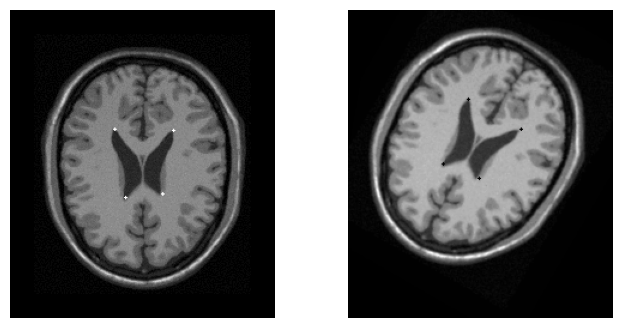

In [47]:
# Read images and display
A = iio.imread('images/brain1.png')
B = iio.imread('images/brain2.png')


# Define control points
A_points = np.array ([[136, 100], [127, 153], [96, 156], [87, 99]])
B_points = np.array ([[144, 99], [109, 140], [79, 128], [100, 74]]) 

# Add control points
A2, B2 = A.copy(), B.copy()
for pa, pb in zip(A_points, B_points):
    cv2.circle(A2, toTuple(pa), 1, (255, 0, 0), -1)
    cv2.circle(B2, toTuple(pb), 1, (0, 0, 255), -1)

# Display images
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A2, cmap='gray')
ax[0].axis('off')
ax[1].imshow(B2, cmap='gray')
ax[1].axis('off')


In [33]:
def rigid_registration (pair1, pair2) :
    """
    Rigid transformation estimation between n pairs of points
    This function returns a rotation R and a translation t
    pair1 : array of size nx2
    pair2 : array of size nx2
    returns transformation matrix T of size 2x3
    """
    pair1 = np.array (pair1)
    pair2 = np.array (pair2)
    
    # computes barycenters, and recenters the points
    m1 = np.mean(pair1, 0)
    m2 = np.mean(pair2, 0)
    pair1_inv_shifted = pair1-m1
    pair2_inv_shifted = pair2-m2
    
    # Evaluates SVD
    K = np.matmul(np.transpose( pair2_inv_shifted ), pair1_inv_shifted)     # Matrice multiplication : K = q'^T * p'
    U,S,V = np.linalg.svd(K)                                                # Singular Value Decomposition
    
    # Computes Rotation
    S = np.eye(2)
    S[1,1] = np.linalg.det(U) * np.linalg.det(V)                            
    R = np.matmul(np.matmul(U, S), np.transpose (V))                        # R = USV^T
    
    # Computes Translation
    t = m2 - np.matmul(R, m1)
    T = np.zeros((2, 3))
    T[0:2, 0:2] = R
    T[0:2, 2] = t
    return T

In [34]:
def applyTransform(points, T):
    """
    Apply transform to a list of points
    points: list of points
    T: rigid transformation matrix (shape 2x3)
    """
    dataA = np.array(points)
    src = np.array([dataA])
    data_dest = cv2.transform(src, T)
    a, b, c = data_dest.shape
    data_dest = np.reshape(data_dest, (b, c))
    return data_dest

(-0.5, 220.5, 256.5, -0.5)

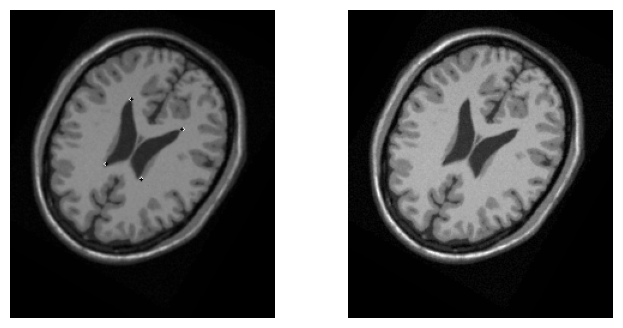

In [48]:
# 1st case, rigid registration, with pairs of points in the correct order
T = rigid_registration(A_points, B_points)

# Apply transformation on control points and display the results
data_dest = applyTransform(A_points, T)
I = B.copy()
for pb, pa in zip(data_dest, B_points):
    cv2.circle(I, toTuple(pa), 1, (255, 0, 0), -1)
    cv2.circle(I, toTuple(pb), 1, (0, 0, 255), -1)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(I, 'gray')
ax[0].axis('off')

# Apply transformation on image
rows, cols = B.shape
dst = cv2.warpAffine(A, T, (cols, rows))
ax[1].imshow(dst, 'gray')
ax[1].axis('off')

## 25.2 ICP-based registration